### Edgar Moises Hernandez-Gonzalez
#### 17/04/20-17/05/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Espectrogramas STFFT (3D)
##### Concatenacion vertical
##### Resize proporcional de 264x4
##### 5 ejecuciones independientes

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [2]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [3]:
x_train = pd.read_csv("Ventaneo-A04T.csv", header=None)
x_test = pd.read_csv("Ventaneo-A04E.csv", header=None)
y_train = pd.read_csv("EtiquetasVentaneo-A04T.csv", header=None)
y_test = pd.read_csv("EtiquetasVentaneo-A04E.csv", header=None)

In [4]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6048, 11000)
(6048, 11000)
(6048, 1)
(6048, 1)


In [5]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 6048
n_samples_test : 6048


In [6]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [0]:
#codificar etiquetas con valores de 0 a nClases-1
#le = LabelEncoder().fit(y_train)
#y_train = le.transform(y_train)
#_test = le.transform(y_test)

In [7]:
#unir 22 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical_resize(data):
  dim = (4, 264) #ancho, alto
  fs = 250
  datos = np.zeros((6048,264,4))
  temporal = np.zeros((528,2))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*500:(j+1)*500]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*24:(j+1)*24, :] = Sxx[8:32, :]
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [8]:
#llamar a unir_espectrogramas_vertical_resize(data)
x_train = unir_espectrogramas_vertical_resize(x_train)
x_test = unir_espectrogramas_vertical_resize(x_test)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000


In [9]:
print(x_train.shape)
print(x_test.shape)

(6048, 264, 4)
(6048, 264, 4)


In [10]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

53.8289390805143
93.96386761158601
0.00013414131871820146
0.0001381846703413442
1.0146952755172398
1.0941751921182155


In [11]:
maximo = np.ceil(np.max(x_train))

#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= maximo
x_test /= maximo

In [12]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.9968322
1.7400717
2.4840983e-06
2.5589752e-06
0.018790642
0.020262498


In [13]:
#convertir de 3D a 4D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(6048, 264, 4, 1)
(6048, 264, 4, 1)


In [14]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
Train on 6048 samples, validate on 6048 samples
Epoch 1/1000
 - 2s - loss: 1.3854 - accuracy: 0.2535 - val_loss: 1.3821 - val_accuracy: 0.2631
Epoch 2/1000
 - 1s - loss: 1.3842 - accuracy: 0.2606 - val_loss: 1.3794 - val_accuracy: 0.2718
Epoch 3/1000
 - 1s - loss: 1.3828 - accuracy: 0.2601 - val_loss: 1.3767 - val_accuracy: 0.2763
Epoch 4/1000
 - 1s - loss: 1.3811 - accuracy: 0.2624 - val_loss: 1.3735 - val_accuracy: 0.2662
Epoch 5/1000
 - 1s - loss: 1.3794 - accuracy: 0.2758 - val_loss: 1.3699 - val_accuracy: 0.2698
Epoch 6/1000
 - 1s - loss: 1.3774 - accuracy: 0.2804 - val_loss: 1.3657 - val_accuracy: 0.2770
Epoch 7/1000
 - 1s - loss: 1.3750 - accuracy: 0.2923 - val_loss: 1.3609 - val_accuracy: 0.2950
Epoch 8/1000
 - 1s - loss: 1.3723 - accuracy: 0.2975 - val_loss: 1.3555 - val_accuracy: 0.3189
Epoch 9/1000
 - 1s - loss: 1.3690 - accuracy: 0.3269 - val_loss: 1.3493 - val_accuracy: 0.3376
Epoch 10/1000
 - 1s - loss: 1.3651 - accuracy: 0.3383 - val_loss: 1.3421 - val_accur

Epoch 86/1000
 - 2s - loss: 1.1357 - accuracy: 0.5116 - val_loss: 1.1941 - val_accuracy: 0.4448
Epoch 87/1000
 - 2s - loss: 1.1354 - accuracy: 0.5046 - val_loss: 1.2008 - val_accuracy: 0.4387
Epoch 88/1000
 - 2s - loss: 1.1338 - accuracy: 0.5088 - val_loss: 1.1937 - val_accuracy: 0.4494
Epoch 89/1000
 - 2s - loss: 1.1284 - accuracy: 0.5157 - val_loss: 1.1969 - val_accuracy: 0.4408
Epoch 90/1000
 - 2s - loss: 1.1229 - accuracy: 0.5139 - val_loss: 1.1964 - val_accuracy: 0.4401
Epoch 91/1000
 - 2s - loss: 1.1211 - accuracy: 0.5190 - val_loss: 1.1967 - val_accuracy: 0.4435
Epoch 92/1000
 - 2s - loss: 1.1173 - accuracy: 0.5203 - val_loss: 1.1933 - val_accuracy: 0.4448
Epoch 93/1000
 - 2s - loss: 1.1220 - accuracy: 0.5222 - val_loss: 1.2005 - val_accuracy: 0.4392
Epoch 94/1000
 - 2s - loss: 1.1188 - accuracy: 0.5197 - val_loss: 1.1992 - val_accuracy: 0.4436
Epoch 95/1000
 - 2s - loss: 1.1180 - accuracy: 0.5203 - val_loss: 1.1970 - val_accuracy: 0.4390
Epoch 96/1000
 - 2s - loss: 1.1096 - acc

Epoch 171/1000
 - 2s - loss: 0.9460 - accuracy: 0.6157 - val_loss: 1.2531 - val_accuracy: 0.4519
Epoch 172/1000
 - 2s - loss: 0.9400 - accuracy: 0.6172 - val_loss: 1.2535 - val_accuracy: 0.4527
Epoch 173/1000
 - 2s - loss: 0.9431 - accuracy: 0.6124 - val_loss: 1.2645 - val_accuracy: 0.4484
Epoch 174/1000
 - 2s - loss: 0.9378 - accuracy: 0.6167 - val_loss: 1.2566 - val_accuracy: 0.4525
Epoch 175/1000
 - 2s - loss: 0.9366 - accuracy: 0.6179 - val_loss: 1.2577 - val_accuracy: 0.4555
Epoch 176/1000
 - 2s - loss: 0.9323 - accuracy: 0.6151 - val_loss: 1.2607 - val_accuracy: 0.4550
Epoch 177/1000
 - 1s - loss: 0.9292 - accuracy: 0.6205 - val_loss: 1.2625 - val_accuracy: 0.4578
Epoch 178/1000
 - 2s - loss: 0.9320 - accuracy: 0.6113 - val_loss: 1.2639 - val_accuracy: 0.4563
Epoch 179/1000
 - 2s - loss: 0.9253 - accuracy: 0.6200 - val_loss: 1.2602 - val_accuracy: 0.4497
Epoch 180/1000
 - 1s - loss: 0.9274 - accuracy: 0.6177 - val_loss: 1.2681 - val_accuracy: 0.4547
Epoch 181/1000
 - 2s - loss: 0

Epoch 256/1000
 - 2s - loss: 0.7995 - accuracy: 0.6870 - val_loss: 1.3615 - val_accuracy: 0.4486
Epoch 257/1000
 - 2s - loss: 0.8021 - accuracy: 0.6820 - val_loss: 1.3537 - val_accuracy: 0.4507
Epoch 258/1000
 - 2s - loss: 0.7978 - accuracy: 0.6784 - val_loss: 1.3563 - val_accuracy: 0.4444
Epoch 259/1000
 - 2s - loss: 0.8020 - accuracy: 0.6774 - val_loss: 1.3672 - val_accuracy: 0.4511
Epoch 260/1000
 - 2s - loss: 0.7876 - accuracy: 0.6921 - val_loss: 1.3709 - val_accuracy: 0.4494
Epoch 261/1000
 - 2s - loss: 0.7987 - accuracy: 0.6781 - val_loss: 1.3705 - val_accuracy: 0.4411
Epoch 262/1000
 - 2s - loss: 0.7973 - accuracy: 0.6817 - val_loss: 1.3672 - val_accuracy: 0.4449
Epoch 263/1000
 - 2s - loss: 0.7844 - accuracy: 0.6868 - val_loss: 1.3602 - val_accuracy: 0.4416
Epoch 264/1000
 - 2s - loss: 0.7924 - accuracy: 0.6895 - val_loss: 1.3684 - val_accuracy: 0.4454
Epoch 265/1000
 - 2s - loss: 0.7912 - accuracy: 0.6840 - val_loss: 1.3848 - val_accuracy: 0.4486
Epoch 266/1000
 - 2s - loss: 0

Epoch 341/1000
 - 2s - loss: 0.6776 - accuracy: 0.7312 - val_loss: 1.4789 - val_accuracy: 0.4413
Epoch 342/1000
 - 2s - loss: 0.6734 - accuracy: 0.7318 - val_loss: 1.4875 - val_accuracy: 0.4436
Epoch 343/1000
 - 2s - loss: 0.6689 - accuracy: 0.7404 - val_loss: 1.4984 - val_accuracy: 0.4459
Epoch 344/1000
 - 2s - loss: 0.6829 - accuracy: 0.7348 - val_loss: 1.4951 - val_accuracy: 0.4451
Epoch 345/1000
 - 2s - loss: 0.6786 - accuracy: 0.7364 - val_loss: 1.4899 - val_accuracy: 0.4406
Epoch 346/1000
 - 2s - loss: 0.6731 - accuracy: 0.7293 - val_loss: 1.4902 - val_accuracy: 0.4435
Epoch 347/1000
 - 2s - loss: 0.6713 - accuracy: 0.7351 - val_loss: 1.4869 - val_accuracy: 0.4439
Epoch 348/1000
 - 2s - loss: 0.6716 - accuracy: 0.7354 - val_loss: 1.4908 - val_accuracy: 0.4413
Epoch 349/1000
 - 2s - loss: 0.6740 - accuracy: 0.7386 - val_loss: 1.4809 - val_accuracy: 0.4398
Epoch 350/1000
 - 2s - loss: 0.6751 - accuracy: 0.7379 - val_loss: 1.5065 - val_accuracy: 0.4443
Epoch 351/1000
 - 2s - loss: 0

Epoch 426/1000
 - 2s - loss: 0.5746 - accuracy: 0.7771 - val_loss: 1.6291 - val_accuracy: 0.4446
Epoch 427/1000
 - 2s - loss: 0.5664 - accuracy: 0.7839 - val_loss: 1.6248 - val_accuracy: 0.4435
Epoch 428/1000
 - 2s - loss: 0.5721 - accuracy: 0.7869 - val_loss: 1.6167 - val_accuracy: 0.4385
Epoch 429/1000
 - 2s - loss: 0.5824 - accuracy: 0.7779 - val_loss: 1.5996 - val_accuracy: 0.4408
Epoch 430/1000
 - 2s - loss: 0.5658 - accuracy: 0.7882 - val_loss: 1.6254 - val_accuracy: 0.4410
Epoch 431/1000
 - 2s - loss: 0.5647 - accuracy: 0.7857 - val_loss: 1.6395 - val_accuracy: 0.4418
Epoch 432/1000
 - 2s - loss: 0.5663 - accuracy: 0.7826 - val_loss: 1.6292 - val_accuracy: 0.4443
Epoch 433/1000
 - 2s - loss: 0.5666 - accuracy: 0.7801 - val_loss: 1.6317 - val_accuracy: 0.4454
Epoch 434/1000
 - 2s - loss: 0.5653 - accuracy: 0.7770 - val_loss: 1.6606 - val_accuracy: 0.4428
Epoch 435/1000
 - 2s - loss: 0.5663 - accuracy: 0.7872 - val_loss: 1.6258 - val_accuracy: 0.4408
Epoch 436/1000
 - 2s - loss: 0

Epoch 511/1000
 - 2s - loss: 0.4866 - accuracy: 0.8198 - val_loss: 1.7340 - val_accuracy: 0.4415
Epoch 512/1000
 - 2s - loss: 0.4850 - accuracy: 0.8203 - val_loss: 1.7819 - val_accuracy: 0.4423
Epoch 513/1000
 - 2s - loss: 0.4783 - accuracy: 0.8213 - val_loss: 1.7706 - val_accuracy: 0.4406
Epoch 514/1000
 - 2s - loss: 0.4783 - accuracy: 0.8232 - val_loss: 1.7642 - val_accuracy: 0.4428
Epoch 515/1000
 - 2s - loss: 0.4866 - accuracy: 0.8226 - val_loss: 1.7682 - val_accuracy: 0.4355
Epoch 516/1000
 - 1s - loss: 0.4820 - accuracy: 0.8150 - val_loss: 1.7811 - val_accuracy: 0.4415
Epoch 517/1000
 - 2s - loss: 0.4799 - accuracy: 0.8223 - val_loss: 1.7747 - val_accuracy: 0.4438
Epoch 518/1000
 - 2s - loss: 0.4656 - accuracy: 0.8322 - val_loss: 1.7696 - val_accuracy: 0.4363
Epoch 519/1000
 - 2s - loss: 0.4838 - accuracy: 0.8171 - val_loss: 1.7665 - val_accuracy: 0.4387
Epoch 520/1000
 - 2s - loss: 0.4819 - accuracy: 0.8216 - val_loss: 1.7906 - val_accuracy: 0.4380
Epoch 521/1000
 - 2s - loss: 0

Epoch 596/1000
 - 2s - loss: 0.4057 - accuracy: 0.8530 - val_loss: 1.9503 - val_accuracy: 0.4358
Epoch 597/1000
 - 2s - loss: 0.4031 - accuracy: 0.8562 - val_loss: 1.9319 - val_accuracy: 0.4431
Epoch 598/1000
 - 2s - loss: 0.4001 - accuracy: 0.8586 - val_loss: 1.9427 - val_accuracy: 0.4390
Epoch 599/1000
 - 2s - loss: 0.3948 - accuracy: 0.8576 - val_loss: 1.9219 - val_accuracy: 0.4408
Epoch 600/1000
 - 2s - loss: 0.3995 - accuracy: 0.8538 - val_loss: 1.9127 - val_accuracy: 0.4413
Epoch 601/1000
 - 2s - loss: 0.4001 - accuracy: 0.8566 - val_loss: 1.9468 - val_accuracy: 0.4410
Epoch 602/1000
 - 2s - loss: 0.3914 - accuracy: 0.8591 - val_loss: 1.9412 - val_accuracy: 0.4387
Epoch 603/1000
 - 2s - loss: 0.4015 - accuracy: 0.8558 - val_loss: 1.9256 - val_accuracy: 0.4418
Epoch 604/1000
 - 2s - loss: 0.3962 - accuracy: 0.8570 - val_loss: 1.9317 - val_accuracy: 0.4367
Epoch 605/1000
 - 2s - loss: 0.4039 - accuracy: 0.8583 - val_loss: 1.9228 - val_accuracy: 0.4408
Epoch 606/1000
 - 2s - loss: 0

Epoch 681/1000
 - 2s - loss: 0.3463 - accuracy: 0.8826 - val_loss: 2.0479 - val_accuracy: 0.4411
Epoch 682/1000
 - 2s - loss: 0.3294 - accuracy: 0.8839 - val_loss: 2.0759 - val_accuracy: 0.4383
Epoch 683/1000
 - 2s - loss: 0.3439 - accuracy: 0.8818 - val_loss: 2.0775 - val_accuracy: 0.4360
Epoch 684/1000
 - 2s - loss: 0.3381 - accuracy: 0.8783 - val_loss: 2.0829 - val_accuracy: 0.4413
Epoch 685/1000
 - 2s - loss: 0.3299 - accuracy: 0.8819 - val_loss: 2.0759 - val_accuracy: 0.4377
Epoch 686/1000
 - 2s - loss: 0.3364 - accuracy: 0.8796 - val_loss: 2.0534 - val_accuracy: 0.4420
Epoch 687/1000
 - 2s - loss: 0.3374 - accuracy: 0.8831 - val_loss: 2.0854 - val_accuracy: 0.4352
Epoch 688/1000
 - 2s - loss: 0.3298 - accuracy: 0.8851 - val_loss: 2.0664 - val_accuracy: 0.4406
Epoch 689/1000
 - 2s - loss: 0.3323 - accuracy: 0.8853 - val_loss: 2.0690 - val_accuracy: 0.4362
Epoch 690/1000
 - 2s - loss: 0.3480 - accuracy: 0.8767 - val_loss: 2.0408 - val_accuracy: 0.4385
Epoch 691/1000
 - 2s - loss: 0

Epoch 766/1000
 - 2s - loss: 0.2837 - accuracy: 0.9033 - val_loss: 2.2247 - val_accuracy: 0.4385
Epoch 767/1000
 - 2s - loss: 0.2816 - accuracy: 0.9013 - val_loss: 2.2240 - val_accuracy: 0.4430
Epoch 768/1000
 - 2s - loss: 0.2818 - accuracy: 0.9069 - val_loss: 2.2126 - val_accuracy: 0.4454
Epoch 769/1000
 - 2s - loss: 0.2818 - accuracy: 0.8986 - val_loss: 2.2185 - val_accuracy: 0.4421
Epoch 770/1000
 - 2s - loss: 0.2885 - accuracy: 0.9018 - val_loss: 2.2172 - val_accuracy: 0.4372
Epoch 771/1000
 - 2s - loss: 0.2826 - accuracy: 0.8985 - val_loss: 2.2500 - val_accuracy: 0.4411
Epoch 772/1000
 - 2s - loss: 0.2795 - accuracy: 0.8980 - val_loss: 2.2322 - val_accuracy: 0.4418
Epoch 773/1000
 - 2s - loss: 0.2851 - accuracy: 0.9020 - val_loss: 2.1900 - val_accuracy: 0.4416
Epoch 774/1000
 - 2s - loss: 0.2771 - accuracy: 0.9054 - val_loss: 2.2398 - val_accuracy: 0.4413
Epoch 775/1000
 - 2s - loss: 0.2738 - accuracy: 0.9059 - val_loss: 2.3084 - val_accuracy: 0.4385
Epoch 776/1000
 - 2s - loss: 0

Epoch 851/1000
 - 2s - loss: 0.2463 - accuracy: 0.9148 - val_loss: 2.3752 - val_accuracy: 0.4385
Epoch 852/1000
 - 2s - loss: 0.2413 - accuracy: 0.9162 - val_loss: 2.4050 - val_accuracy: 0.4423
Epoch 853/1000
 - 2s - loss: 0.2368 - accuracy: 0.9218 - val_loss: 2.3606 - val_accuracy: 0.4433
Epoch 854/1000
 - 2s - loss: 0.2362 - accuracy: 0.9231 - val_loss: 2.3713 - val_accuracy: 0.4443
Epoch 855/1000
 - 2s - loss: 0.2377 - accuracy: 0.9155 - val_loss: 2.4099 - val_accuracy: 0.4403
Epoch 856/1000
 - 2s - loss: 0.2354 - accuracy: 0.9220 - val_loss: 2.3704 - val_accuracy: 0.4433
Epoch 857/1000
 - 2s - loss: 0.2338 - accuracy: 0.9243 - val_loss: 2.3794 - val_accuracy: 0.4406
Epoch 858/1000
 - 2s - loss: 0.2354 - accuracy: 0.9215 - val_loss: 2.3861 - val_accuracy: 0.4430
Epoch 859/1000
 - 2s - loss: 0.2294 - accuracy: 0.9231 - val_loss: 2.3712 - val_accuracy: 0.4408
Epoch 860/1000
 - 2s - loss: 0.2387 - accuracy: 0.9188 - val_loss: 2.3719 - val_accuracy: 0.4403
Epoch 861/1000
 - 2s - loss: 0

Epoch 936/1000
 - 2s - loss: 0.1999 - accuracy: 0.9358 - val_loss: 2.5821 - val_accuracy: 0.4431
Epoch 937/1000
 - 2s - loss: 0.2073 - accuracy: 0.9296 - val_loss: 2.5242 - val_accuracy: 0.4468
Epoch 938/1000
 - 2s - loss: 0.2056 - accuracy: 0.9306 - val_loss: 2.4977 - val_accuracy: 0.4458
Epoch 939/1000
 - 1s - loss: 0.1977 - accuracy: 0.9340 - val_loss: 2.5907 - val_accuracy: 0.4435
Epoch 940/1000
 - 2s - loss: 0.2010 - accuracy: 0.9309 - val_loss: 2.5424 - val_accuracy: 0.4446
Epoch 941/1000
 - 1s - loss: 0.2019 - accuracy: 0.9319 - val_loss: 2.5385 - val_accuracy: 0.4428
Epoch 942/1000
 - 2s - loss: 0.1999 - accuracy: 0.9363 - val_loss: 2.5592 - val_accuracy: 0.4420
Epoch 943/1000
 - 2s - loss: 0.1977 - accuracy: 0.9322 - val_loss: 2.5687 - val_accuracy: 0.4408
Epoch 944/1000
 - 2s - loss: 0.1918 - accuracy: 0.9382 - val_loss: 2.6204 - val_accuracy: 0.4410
Epoch 945/1000
 - 2s - loss: 0.1944 - accuracy: 0.9372 - val_loss: 2.5678 - val_accuracy: 0.4430
Epoch 946/1000
 - 2s - loss: 0

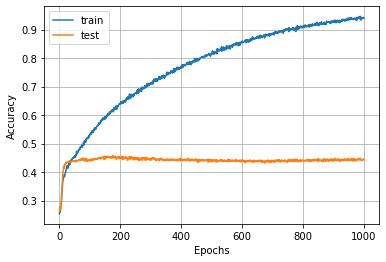

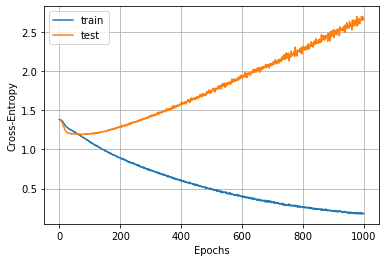

Iteration: 2
Train on 6048 samples, validate on 6048 samples
Epoch 1/1000
 - 1s - loss: 1.3851 - accuracy: 0.2503 - val_loss: 1.3803 - val_accuracy: 0.2391
Epoch 2/1000
 - 2s - loss: 1.3834 - accuracy: 0.2553 - val_loss: 1.3759 - val_accuracy: 0.2517
Epoch 3/1000
 - 2s - loss: 1.3813 - accuracy: 0.2591 - val_loss: 1.3714 - val_accuracy: 0.2583
Epoch 4/1000
 - 2s - loss: 1.3791 - accuracy: 0.2867 - val_loss: 1.3673 - val_accuracy: 0.2852
Epoch 5/1000
 - 2s - loss: 1.3771 - accuracy: 0.2844 - val_loss: 1.3621 - val_accuracy: 0.2917
Epoch 6/1000
 - 2s - loss: 1.3747 - accuracy: 0.2940 - val_loss: 1.3568 - val_accuracy: 0.3208
Epoch 7/1000
 - 2s - loss: 1.3722 - accuracy: 0.3047 - val_loss: 1.3507 - val_accuracy: 0.3429
Epoch 8/1000
 - 2s - loss: 1.3696 - accuracy: 0.3213 - val_loss: 1.3441 - val_accuracy: 0.3704
Epoch 9/1000
 - 2s - loss: 1.3657 - accuracy: 0.3385 - val_loss: 1.3365 - val_accuracy: 0.3981
Epoch 10/1000
 - 1s - loss: 1.3611 - accuracy: 0.3519 - val_loss: 1.3274 - val_accur

Epoch 86/1000
 - 1s - loss: 1.1487 - accuracy: 0.4987 - val_loss: 1.1949 - val_accuracy: 0.4458
Epoch 87/1000
 - 2s - loss: 1.1533 - accuracy: 0.4954 - val_loss: 1.1998 - val_accuracy: 0.4363
Epoch 88/1000
 - 2s - loss: 1.1445 - accuracy: 0.4980 - val_loss: 1.1962 - val_accuracy: 0.4411
Epoch 89/1000
 - 2s - loss: 1.1473 - accuracy: 0.5046 - val_loss: 1.1957 - val_accuracy: 0.4415
Epoch 90/1000
 - 2s - loss: 1.1438 - accuracy: 0.5064 - val_loss: 1.1992 - val_accuracy: 0.4408
Epoch 91/1000
 - 2s - loss: 1.1379 - accuracy: 0.5043 - val_loss: 1.1989 - val_accuracy: 0.4435
Epoch 92/1000
 - 2s - loss: 1.1363 - accuracy: 0.5069 - val_loss: 1.1987 - val_accuracy: 0.4411
Epoch 93/1000
 - 1s - loss: 1.1352 - accuracy: 0.5103 - val_loss: 1.1976 - val_accuracy: 0.4433
Epoch 94/1000
 - 2s - loss: 1.1303 - accuracy: 0.5195 - val_loss: 1.2001 - val_accuracy: 0.4425
Epoch 95/1000
 - 2s - loss: 1.1353 - accuracy: 0.5146 - val_loss: 1.2001 - val_accuracy: 0.4439
Epoch 96/1000
 - 1s - loss: 1.1254 - acc

Epoch 171/1000
 - 2s - loss: 0.9792 - accuracy: 0.5903 - val_loss: 1.2558 - val_accuracy: 0.4435
Epoch 172/1000
 - 2s - loss: 0.9791 - accuracy: 0.5939 - val_loss: 1.2558 - val_accuracy: 0.4469
Epoch 173/1000
 - 2s - loss: 0.9729 - accuracy: 0.5952 - val_loss: 1.2599 - val_accuracy: 0.4464
Epoch 174/1000
 - 2s - loss: 0.9758 - accuracy: 0.5979 - val_loss: 1.2526 - val_accuracy: 0.4499
Epoch 175/1000
 - 2s - loss: 0.9739 - accuracy: 0.5944 - val_loss: 1.2496 - val_accuracy: 0.4492
Epoch 176/1000
 - 2s - loss: 0.9640 - accuracy: 0.5956 - val_loss: 1.2622 - val_accuracy: 0.4468
Epoch 177/1000
 - 2s - loss: 0.9654 - accuracy: 0.5964 - val_loss: 1.2655 - val_accuracy: 0.4479
Epoch 178/1000
 - 2s - loss: 0.9697 - accuracy: 0.5957 - val_loss: 1.2584 - val_accuracy: 0.4497
Epoch 179/1000
 - 2s - loss: 0.9609 - accuracy: 0.6048 - val_loss: 1.2587 - val_accuracy: 0.4506
Epoch 180/1000
 - 2s - loss: 0.9618 - accuracy: 0.6028 - val_loss: 1.2527 - val_accuracy: 0.4456
Epoch 181/1000
 - 2s - loss: 0

Epoch 256/1000
 - 2s - loss: 0.8456 - accuracy: 0.6569 - val_loss: 1.3518 - val_accuracy: 0.4577
Epoch 257/1000
 - 2s - loss: 0.8413 - accuracy: 0.6597 - val_loss: 1.3470 - val_accuracy: 0.4461
Epoch 258/1000
 - 2s - loss: 0.8365 - accuracy: 0.6630 - val_loss: 1.3565 - val_accuracy: 0.4491
Epoch 259/1000
 - 2s - loss: 0.8397 - accuracy: 0.6617 - val_loss: 1.3596 - val_accuracy: 0.4497
Epoch 260/1000
 - 2s - loss: 0.8377 - accuracy: 0.6607 - val_loss: 1.3437 - val_accuracy: 0.4552
Epoch 261/1000
 - 2s - loss: 0.8409 - accuracy: 0.6597 - val_loss: 1.3581 - val_accuracy: 0.4529
Epoch 262/1000
 - 2s - loss: 0.8368 - accuracy: 0.6648 - val_loss: 1.3565 - val_accuracy: 0.4509
Epoch 263/1000
 - 2s - loss: 0.8351 - accuracy: 0.6615 - val_loss: 1.3587 - val_accuracy: 0.4471
Epoch 264/1000
 - 2s - loss: 0.8357 - accuracy: 0.6558 - val_loss: 1.3558 - val_accuracy: 0.4554
Epoch 265/1000
 - 2s - loss: 0.8305 - accuracy: 0.6665 - val_loss: 1.3705 - val_accuracy: 0.4487
Epoch 266/1000
 - 2s - loss: 0

Epoch 341/1000
 - 2s - loss: 0.7357 - accuracy: 0.7118 - val_loss: 1.4631 - val_accuracy: 0.4449
Epoch 342/1000
 - 2s - loss: 0.7253 - accuracy: 0.7120 - val_loss: 1.4756 - val_accuracy: 0.4439
Epoch 343/1000
 - 2s - loss: 0.7221 - accuracy: 0.7138 - val_loss: 1.4735 - val_accuracy: 0.4489
Epoch 344/1000
 - 1s - loss: 0.7233 - accuracy: 0.7141 - val_loss: 1.4505 - val_accuracy: 0.4563
Epoch 345/1000
 - 2s - loss: 0.7245 - accuracy: 0.7115 - val_loss: 1.4655 - val_accuracy: 0.4463
Epoch 346/1000
 - 2s - loss: 0.7177 - accuracy: 0.7184 - val_loss: 1.4608 - val_accuracy: 0.4507
Epoch 347/1000
 - 2s - loss: 0.7142 - accuracy: 0.7149 - val_loss: 1.4783 - val_accuracy: 0.4469
Epoch 348/1000
 - 2s - loss: 0.7185 - accuracy: 0.7174 - val_loss: 1.4660 - val_accuracy: 0.4497
Epoch 349/1000
 - 1s - loss: 0.7210 - accuracy: 0.7128 - val_loss: 1.4865 - val_accuracy: 0.4506
Epoch 350/1000
 - 2s - loss: 0.7082 - accuracy: 0.7197 - val_loss: 1.4743 - val_accuracy: 0.4446
Epoch 351/1000
 - 2s - loss: 0

Epoch 426/1000
 - 2s - loss: 0.6148 - accuracy: 0.7604 - val_loss: 1.5875 - val_accuracy: 0.4517
Epoch 427/1000
 - 2s - loss: 0.6138 - accuracy: 0.7662 - val_loss: 1.5812 - val_accuracy: 0.4504
Epoch 428/1000
 - 1s - loss: 0.6192 - accuracy: 0.7624 - val_loss: 1.5918 - val_accuracy: 0.4517
Epoch 429/1000
 - 1s - loss: 0.6188 - accuracy: 0.7598 - val_loss: 1.5851 - val_accuracy: 0.4512
Epoch 430/1000
 - 2s - loss: 0.6160 - accuracy: 0.7569 - val_loss: 1.6160 - val_accuracy: 0.4497
Epoch 431/1000
 - 1s - loss: 0.6106 - accuracy: 0.7589 - val_loss: 1.5788 - val_accuracy: 0.4534
Epoch 432/1000
 - 2s - loss: 0.6119 - accuracy: 0.7642 - val_loss: 1.6046 - val_accuracy: 0.4461
Epoch 433/1000
 - 2s - loss: 0.6201 - accuracy: 0.7588 - val_loss: 1.5971 - val_accuracy: 0.4433
Epoch 434/1000
 - 2s - loss: 0.6126 - accuracy: 0.7655 - val_loss: 1.6297 - val_accuracy: 0.4468
Epoch 435/1000
 - 2s - loss: 0.6138 - accuracy: 0.7657 - val_loss: 1.6142 - val_accuracy: 0.4471
Epoch 436/1000
 - 2s - loss: 0

Epoch 511/1000
 - 2s - loss: 0.5266 - accuracy: 0.8029 - val_loss: 1.7405 - val_accuracy: 0.4539
Epoch 512/1000
 - 2s - loss: 0.5233 - accuracy: 0.8089 - val_loss: 1.7232 - val_accuracy: 0.4524
Epoch 513/1000
 - 2s - loss: 0.5204 - accuracy: 0.8022 - val_loss: 1.7544 - val_accuracy: 0.4484
Epoch 514/1000
 - 2s - loss: 0.5230 - accuracy: 0.7978 - val_loss: 1.7653 - val_accuracy: 0.4482
Epoch 515/1000
 - 2s - loss: 0.5195 - accuracy: 0.8070 - val_loss: 1.7447 - val_accuracy: 0.4580
Epoch 516/1000
 - 2s - loss: 0.5219 - accuracy: 0.8072 - val_loss: 1.7480 - val_accuracy: 0.4539
Epoch 517/1000
 - 2s - loss: 0.5198 - accuracy: 0.8046 - val_loss: 1.7388 - val_accuracy: 0.4560
Epoch 518/1000
 - 2s - loss: 0.5267 - accuracy: 0.8080 - val_loss: 1.7378 - val_accuracy: 0.4540
Epoch 519/1000
 - 2s - loss: 0.5156 - accuracy: 0.8067 - val_loss: 1.7733 - val_accuracy: 0.4473
Epoch 520/1000
 - 2s - loss: 0.5282 - accuracy: 0.7999 - val_loss: 1.7503 - val_accuracy: 0.4509
Epoch 521/1000
 - 2s - loss: 0

Epoch 596/1000
 - 2s - loss: 0.4434 - accuracy: 0.8356 - val_loss: 1.8932 - val_accuracy: 0.4463
Epoch 597/1000
 - 2s - loss: 0.4408 - accuracy: 0.8358 - val_loss: 1.8968 - val_accuracy: 0.4456
Epoch 598/1000
 - 2s - loss: 0.4402 - accuracy: 0.8338 - val_loss: 1.8962 - val_accuracy: 0.4466
Epoch 599/1000
 - 2s - loss: 0.4443 - accuracy: 0.8338 - val_loss: 1.9185 - val_accuracy: 0.4461
Epoch 600/1000
 - 2s - loss: 0.4387 - accuracy: 0.8413 - val_loss: 1.8883 - val_accuracy: 0.4497
Epoch 601/1000
 - 2s - loss: 0.4392 - accuracy: 0.8401 - val_loss: 1.8866 - val_accuracy: 0.4524
Epoch 602/1000
 - 2s - loss: 0.4392 - accuracy: 0.8376 - val_loss: 1.9288 - val_accuracy: 0.4446
Epoch 603/1000
 - 2s - loss: 0.4481 - accuracy: 0.8353 - val_loss: 1.8699 - val_accuracy: 0.4501
Epoch 604/1000
 - 2s - loss: 0.4435 - accuracy: 0.8356 - val_loss: 1.8767 - val_accuracy: 0.4506
Epoch 605/1000
 - 2s - loss: 0.4374 - accuracy: 0.8368 - val_loss: 1.9009 - val_accuracy: 0.4540
Epoch 606/1000
 - 2s - loss: 0

Epoch 681/1000
 - 2s - loss: 0.3756 - accuracy: 0.8647 - val_loss: 2.0398 - val_accuracy: 0.4507
Epoch 682/1000
 - 2s - loss: 0.3820 - accuracy: 0.8626 - val_loss: 2.0050 - val_accuracy: 0.4486
Epoch 683/1000
 - 2s - loss: 0.3698 - accuracy: 0.8657 - val_loss: 2.0523 - val_accuracy: 0.4496
Epoch 684/1000
 - 2s - loss: 0.3784 - accuracy: 0.8654 - val_loss: 2.0198 - val_accuracy: 0.4534
Epoch 685/1000
 - 1s - loss: 0.3811 - accuracy: 0.8646 - val_loss: 2.0277 - val_accuracy: 0.4525
Epoch 686/1000
 - 1s - loss: 0.3766 - accuracy: 0.8664 - val_loss: 2.1132 - val_accuracy: 0.4496
Epoch 687/1000
 - 2s - loss: 0.3790 - accuracy: 0.8641 - val_loss: 2.0641 - val_accuracy: 0.4464
Epoch 688/1000
 - 2s - loss: 0.3779 - accuracy: 0.8666 - val_loss: 2.0357 - val_accuracy: 0.4439
Epoch 689/1000
 - 2s - loss: 0.3741 - accuracy: 0.8654 - val_loss: 2.1260 - val_accuracy: 0.4463
Epoch 690/1000
 - 2s - loss: 0.3688 - accuracy: 0.8679 - val_loss: 2.0552 - val_accuracy: 0.4502
Epoch 691/1000
 - 2s - loss: 0

Epoch 766/1000
 - 2s - loss: 0.3244 - accuracy: 0.8856 - val_loss: 2.1927 - val_accuracy: 0.4535
Epoch 767/1000
 - 2s - loss: 0.3174 - accuracy: 0.8881 - val_loss: 2.2538 - val_accuracy: 0.4517
Epoch 768/1000
 - 2s - loss: 0.3246 - accuracy: 0.8853 - val_loss: 2.1686 - val_accuracy: 0.4517
Epoch 769/1000
 - 2s - loss: 0.3178 - accuracy: 0.8857 - val_loss: 2.1894 - val_accuracy: 0.4444
Epoch 770/1000
 - 2s - loss: 0.3127 - accuracy: 0.8943 - val_loss: 2.2206 - val_accuracy: 0.4540
Epoch 771/1000
 - 2s - loss: 0.3136 - accuracy: 0.8905 - val_loss: 2.2080 - val_accuracy: 0.4466
Epoch 772/1000
 - 2s - loss: 0.3201 - accuracy: 0.8823 - val_loss: 2.2021 - val_accuracy: 0.4511
Epoch 773/1000
 - 2s - loss: 0.3105 - accuracy: 0.8925 - val_loss: 2.2032 - val_accuracy: 0.4478
Epoch 774/1000
 - 2s - loss: 0.3096 - accuracy: 0.8886 - val_loss: 2.2653 - val_accuracy: 0.4439
Epoch 775/1000
 - 2s - loss: 0.3289 - accuracy: 0.8796 - val_loss: 2.2241 - val_accuracy: 0.4481
Epoch 776/1000
 - 2s - loss: 0

Epoch 851/1000
 - 2s - loss: 0.2656 - accuracy: 0.9079 - val_loss: 2.3841 - val_accuracy: 0.4458
Epoch 852/1000
 - 1s - loss: 0.2644 - accuracy: 0.9089 - val_loss: 2.3805 - val_accuracy: 0.4449
Epoch 853/1000
 - 2s - loss: 0.2722 - accuracy: 0.9084 - val_loss: 2.3609 - val_accuracy: 0.4458
Epoch 854/1000
 - 2s - loss: 0.2723 - accuracy: 0.9028 - val_loss: 2.3416 - val_accuracy: 0.4466
Epoch 855/1000
 - 2s - loss: 0.2675 - accuracy: 0.9028 - val_loss: 2.4278 - val_accuracy: 0.4482
Epoch 856/1000
 - 2s - loss: 0.2693 - accuracy: 0.9034 - val_loss: 2.3520 - val_accuracy: 0.4473
Epoch 857/1000
 - 2s - loss: 0.2764 - accuracy: 0.9038 - val_loss: 2.3962 - val_accuracy: 0.4478
Epoch 858/1000
 - 2s - loss: 0.2755 - accuracy: 0.9016 - val_loss: 2.4112 - val_accuracy: 0.4473
Epoch 859/1000
 - 2s - loss: 0.2747 - accuracy: 0.9028 - val_loss: 2.3742 - val_accuracy: 0.4487
Epoch 860/1000
 - 2s - loss: 0.2648 - accuracy: 0.9082 - val_loss: 2.3982 - val_accuracy: 0.4499
Epoch 861/1000
 - 2s - loss: 0

Epoch 936/1000
 - 2s - loss: 0.2272 - accuracy: 0.9201 - val_loss: 2.4897 - val_accuracy: 0.4497
Epoch 937/1000
 - 2s - loss: 0.2330 - accuracy: 0.9236 - val_loss: 2.5177 - val_accuracy: 0.4466
Epoch 938/1000
 - 2s - loss: 0.2364 - accuracy: 0.9188 - val_loss: 2.5432 - val_accuracy: 0.4499
Epoch 939/1000
 - 2s - loss: 0.2321 - accuracy: 0.9188 - val_loss: 2.5515 - val_accuracy: 0.4454
Epoch 940/1000
 - 2s - loss: 0.2257 - accuracy: 0.9225 - val_loss: 2.5103 - val_accuracy: 0.4451
Epoch 941/1000
 - 2s - loss: 0.2344 - accuracy: 0.9206 - val_loss: 2.5132 - val_accuracy: 0.4506
Epoch 942/1000
 - 2s - loss: 0.2293 - accuracy: 0.9211 - val_loss: 2.5636 - val_accuracy: 0.4502
Epoch 943/1000
 - 2s - loss: 0.2228 - accuracy: 0.9218 - val_loss: 2.5455 - val_accuracy: 0.4481
Epoch 944/1000
 - 2s - loss: 0.2267 - accuracy: 0.9233 - val_loss: 2.4927 - val_accuracy: 0.4499
Epoch 945/1000
 - 2s - loss: 0.2311 - accuracy: 0.9200 - val_loss: 2.5152 - val_accuracy: 0.4435
Epoch 946/1000
 - 2s - loss: 0

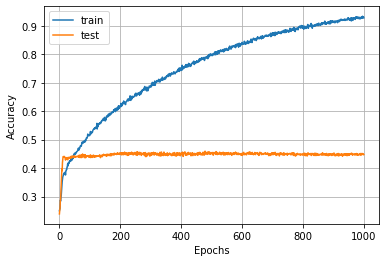

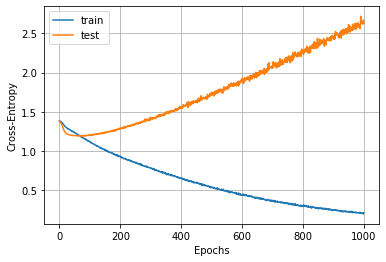


Resultados:
loss: [2.6671871619407463, 2.6290636902290676]
accuracy: [0.443452388048172, 0.4474206268787384]
kappa: [0.2579365079365079, 0.26322751322751325]
Tiempo: 3475.7795464992523


In [15]:
inicio = time.time()
array_loss = []
array_acc = []
array_kappa = []
for i in range(2):
  print("Iteration:", i+1)
    
  model = CNN_2D()

  history = model.fit(x_train, y_train, epochs=1000, batch_size=512,
                      validation_data=(x_test, y_test), verbose=2)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
fin = time.time()
print("Tiempo:", fin - inicio)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 264, 4, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 132, 2, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 132, 2, 16)        2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 66, 1, 16)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1056)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               135296    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [17]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.4454
std: (+/- 0.0020)
Mean Kappa: 0.2606
std: (+/- 0.0026)
Max Accuracy: 0.4474
Max Kappa: 0.2632
